# 📘 Introduction: Bitcoin Data Processing & Visualization

This notebook serves as a practical walkthrough for working with real-time and historical Bitcoin pricing data using the CoinGecko API. 

We demonstrate how to:

- Fetch historical Bitcoin prices for the past 365 days.
- Store the data in an SQLite database (`bitcoin_data.db`) using Python.
- Ensure there are **no duplicate entries** by normalizing timestamps and using database constraints.
- Calculate and visualize **moving averages** to identify trends.
- Perform **z-score analysis** to detect anomalies or unusually high/low prices.
- Generate interactive plots using `matplotlib` or Vega-Lite (via Datasette dashboards).

This notebook complements the Datasette dashboard by preparing and validating the underlying data. You can also use this as a standalone script to inspect and experiment with the data pipeline or modeling logic before visualizing results in a live dashboard.


### Loading functions and libraries


In [1]:
# Load utility functions and libraries
from bitcoin_utils import (
    fetch_historical_bitcoin_prices,
    fetch_current_price,
    save_to_sqlite,
    init_db,
    calculate_moving_averages,
    calculate_volatility,
    detect_anomalies_zscore,
    generate_trend_indicators,
    decompose_time_series
)

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


### Ensure the DB and table exist

In [2]:
# Ensure the DB and table exist
init_db()
print("Database initialized.")

Database initialized.


### Get historical Bitcoin price data (last 365 days)

In [ ]:

df_hist = fetch_historical_bitcoin_prices(days=365)#, interval="daily")
save_to_sqlite(df_hist, "data/bitcoin_data.db")
df_hist.tail()
print("Historical data saved.")

✅ Inserted 0 new rows (skipped duplicates).
Historical data saved.


### (Optional) Fetch and save current price snapshot

In [ ]:

df_now = fetch_current_price()
save_to_sqlite(df_now, "data/bitcoin_data.db")
print("Current price saved.")
df_now


✅ Inserted 0 new rows (skipped duplicates).
Current price saved.


,timestamp,price
0,2025-05-17,103114


### Load all saved price data from SQLite

In [ ]:

conn = sqlite3.connect("data/bitcoin_data.db")
df = pd.read_sql_query("SELECT * FROM bitcoin_prices ORDER BY timestamp DESC", conn)
conn.close()

df['timestamp'] = pd.to_datetime(df['timestamp'], format='ISO8601', utc=True, errors='coerce')
df = df.sort_values("timestamp")
df.tail()


,timestamp,price
4,2025-05-13 00:00:00+00:00,102876.830429
3,2025-05-14 00:00:00+00:00,104184.490393
2,2025-05-15 00:00:00+00:00,103594.425751
1,2025-05-16 00:00:00+00:00,103708.851364
0,2025-05-17 00:00:00+00:00,103556.034940


### Basic line chart

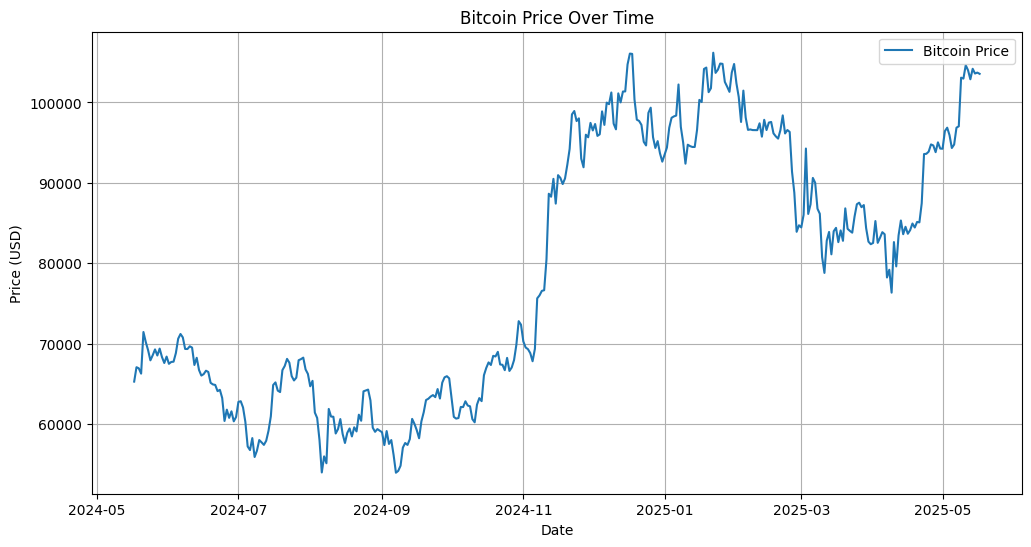

In [ ]:


plt.figure(figsize=(12,6))
plt.plot(df['timestamp'], df ['price'], label='Bitcoin Price')
plt.title("Bitcoin Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.legend()
plt.show()

### Bitcoin Prices with Moving Averages

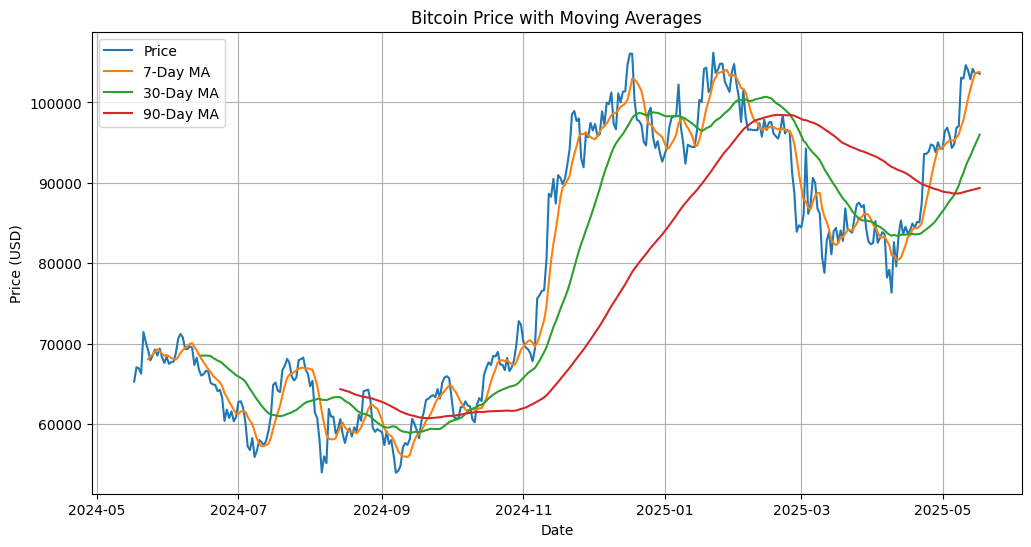

In [20]:
df_ma = calculate_moving_averages(df)

plt.figure(figsize=(12, 6))
plt.plot(df_ma['timestamp'], df_ma['price'], label='Price')
plt.plot(df_ma['timestamp'], df_ma['MA_7'], label='7-Day MA')
plt.plot(df_ma['timestamp'], df_ma['MA_30'], label='30-Day MA')
plt.plot(df_ma['timestamp'], df_ma['MA_90'], label='90-Day MA')
plt.title("Bitcoin Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.legend()
plt.show()


### Rolling Volatility

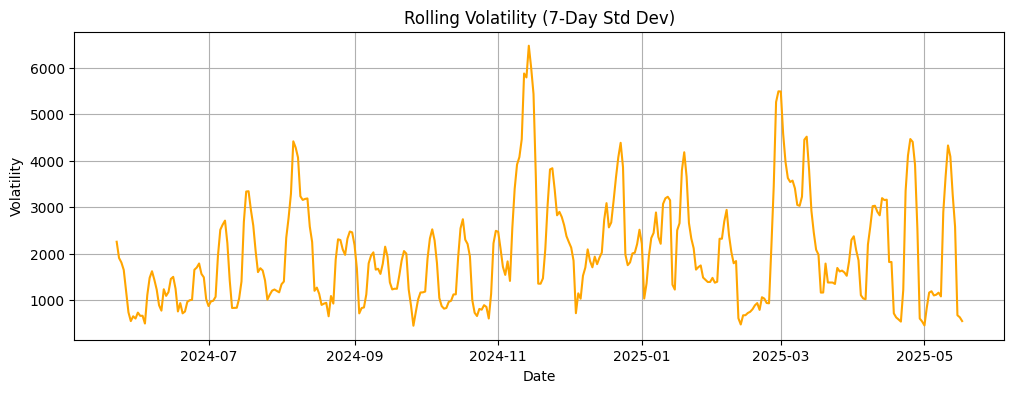

In [22]:
df_vol = calculate_volatility(df)

plt.figure(figsize=(12, 4))
plt.plot(df_vol['timestamp'], df_vol['volatility'], color='orange')
plt.title("Rolling Volatility (7-Day Std Dev)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.grid(True)
plt.show()


### Anamoly Detection (Z Score)

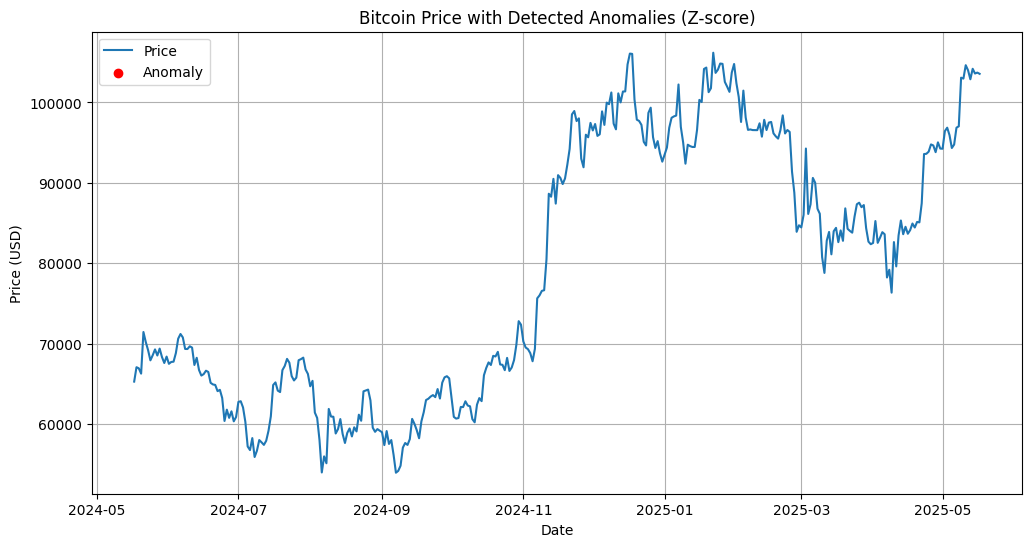

In [23]:
df_anom = detect_anomalies_zscore(df)

plt.figure(figsize=(12, 6))
plt.plot(df_anom['timestamp'], df_anom['price'], label='Price')
plt.scatter(df_anom[df_anom['anomaly_z']]['timestamp'], 
            df_anom[df_anom['anomaly_z']]['price'],
            color='red', label='Anomaly', zorder=5)
plt.title("Bitcoin Price with Detected Anomalies (Z-score)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.legend()
plt.show()


### Cumulative Return of Bitcoin Over Time

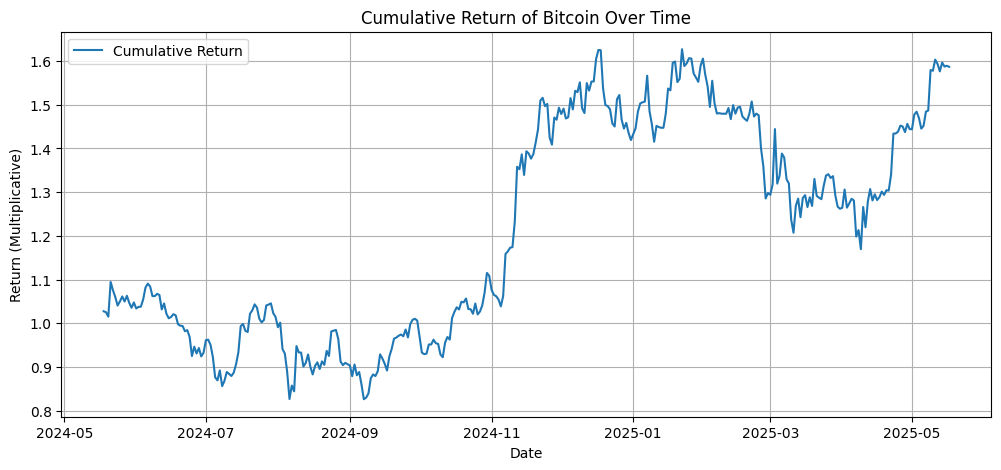

In [24]:
df_trend = generate_trend_indicators(df)

plt.figure(figsize=(12, 5))
plt.plot(df_trend['timestamp'], df_trend['cumulative_return'], label='Cumulative Return')
plt.title("Cumulative Return of Bitcoin Over Time")
plt.xlabel("Date")
plt.ylabel("Return (Multiplicative)")
plt.grid(True)
plt.legend()
plt.show()


### Trends

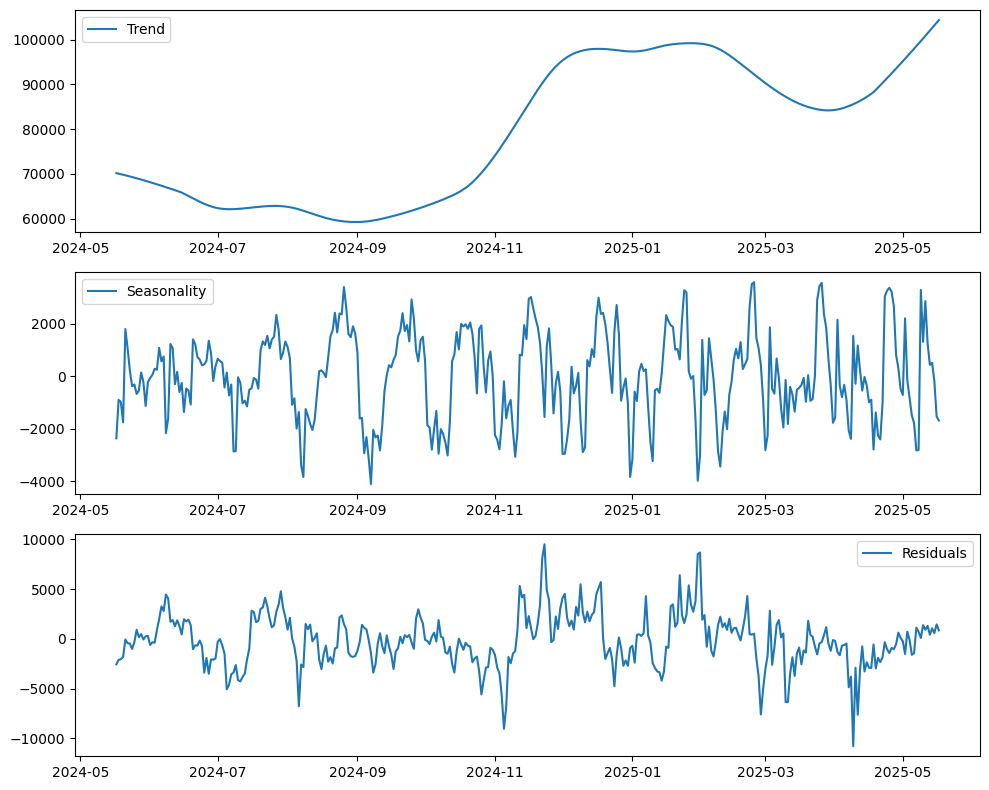

In [25]:
decomp_df = decompose_time_series(df, period=30, plot=True)


## Summary

This notebook demonstrates a full real-time Bitcoin data pipeline:

- Data is fetched via CoinGecko and stored in SQLite
- Time series analytics include:
  - Moving Averages
  - Volatility estimation
  - Anomaly detection using Z-score
  - Cumulative return and trend indicators
  - STL decomposition of the price signal

These tools can help identify trading patterns, detect outliers, and monitor price stability in dynamic markets like crypto.
